In [1]:
import os
os.chdir('../app')

In [2]:
import frontend.stock_analytics as salib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime,timedelta
from pprint import pprint
import matplotlib.patches as patches
import time
import numpy as np
import datetime
import copy
import preprocessing.lob.s03_fill_cache as l03
import re
import preprocessing.preglobal as pg
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
from matplotlib import rc

In [4]:
import cv2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pymongo import MongoClient, UpdateMany, UpdateOne, InsertOne
import pandas as pd

In [5]:
url='mongodb://192.168.0.94:27017/'
client = MongoClient(url)
tbl = client['global']['keynotes']
tbl2 = client['global']['timekeys']

In [6]:
folder = "Thesis/generated_figures/"

In [7]:
def graph_pre(size=1):
    rc('font',**{'family':'serif','serif':['Times']})
    rc('text', usetex=True)
    h = [0,3,5][size]
    
    plt.rcParams["figure.figsize"] = (7.5,h)
    
def graph_post():
    plt.tight_layout()

In [8]:
# Load all Graphs
sa_array = []
for i in pg.get_kn_entries({'selected':1}):
    print('load',i['id'])
    sa_array.append({'kn':i,'sa':salib.stock_analytics(i['id'], gui_mode=False)})


mongo mongodb://192.168.0.94:27017/
load 20190910_AAPL
redis 192.168.0.94
load 20190325_AAPL
redis 192.168.0.94
load 20181030_AAPL
redis 192.168.0.94
load 20180912_AAPL
redis 192.168.0.94
load 20180604_AAPL
redis 192.168.0.94
load 20180327_AAPL
redis 192.168.0.94
load 20170912_AAPL
redis 192.168.0.94
load 20170605_AAPL
redis 192.168.0.94
load 20161027_AAPL
redis 192.168.0.94
load 20160907_AAPL
redis 192.168.0.94
load 20160613_AAPL
redis 192.168.0.94
load 20160321_AAPL
redis 192.168.0.94
load 20150909_AAPL
redis 192.168.0.94
load 20150608_AAPL
redis 192.168.0.94
load 20150309_AAPL
redis 192.168.0.94


In [9]:
salib.time_as_string = False
filte = copy.deepcopy(sa_array[0]['sa'].filters['default'])
g = sa_array[0]['sa'].graphlist['marketorder_num']

In [10]:
filte['numbins']=100
filte['range']['time'] = [9.6*3600*1000, 15.9*3600*1000]
f = filte

In [11]:

def timetoimshowaxis(t, xaxis):
    scale = xaxis[1]-xaxis[0] # equals 1
    offset = xaxis[0]
    return -0.5 + (t-offset)/scale


In [12]:
def xticks(xaxis, no_labels=5, mapf=None, isy=False):
    x = np.array(xaxis)
    nx = x.shape[0]

    step_x = int(nx / (no_labels - 1)) # step between consecutive labels
    x_positions = np.arange(0,nx,step_x) # pixel count at label position
    x_labels = x[::step_x] # labels you want to see
    if mapf:
        x_labels = mapf(x_labels)
    f = plt.yticks if isy else plt.xticks
    f(x_positions, x_labels)
def yticks(xaxis, no_labels=5,  mapf=None):
    xticks(xaxis=xaxis,no_labels=no_labels, mapf=mapf,isy=True)

In [13]:
filte['numbins']=100
filte['range']['time'] = [9.6*3600*1000, 15.9*3600*1000]
f = filte

In [14]:
def tslice(t,a,b):
    f = np.array([i>=salib.to_date_i(a) and i<salib.to_date_i(b) for i in t[0]])
    return (np.array(t[0])[f], np.array(t[1])[f])

In [15]:
video_hd_folder = '../../data/video_hd'
ocr_folder = '../../data/ocr'
timealignment_folder = '../../../../data/timealignment'

In [16]:
def get_subtitles(i, start, stop): 


    cs = client[i]['subtitle'] .aggregate(
               [

                   {"$match":{"startTime":{"$lte":stop, "$gte":start},
                             }},
                   {"$sort":{"startTime":1, "word":1}}

               ]
            )
    res = pd.DataFrame(list(cs))
    # Delete duplicates
    prevword = ''
    for index, row in res.iterrows():
        if row['word'] == prevword:
            res.drop(index, inplace=True)
        prevword = row['word']
    sentences = []
    lsentence = -1
    csentence = ''
    if len(res.index) == 0:
        return []
    
    stime = res.head(1)['startTime'][0]
    for index, row in res.iterrows():
        if row['sentence'] != lsentence and lsentence!=-1:
            sentences.append({'a':stime, 'b':etime, 's':csentence})
            csentence = ''
            stime = row['startTime']
        etime = row['endTime']
        lsentence = row['sentence']
        csentence += row['word']+' '
    sentences.append({'a':stime, 'b':etime, 's':csentence})
    return sentences

In [18]:
def get_mentions_subtitles(keywords):
    # Get all sentences
    cs = client[sa['kn']['id']]['subtitle'] .aggregate([{"$sort":{"startTime":1, "word":1}} ]
            )
    res = pd.DataFrame(list(cs))
    

    # Delete duplicates
    prevword = ''
    for index, row in res.iterrows():
        if row['word'] == prevword:
            res.drop(index, inplace=True)
        prevword = row['word']

    
    
    
    mentions = {}
    ftime = 0
    for kw in keywords:
        ci = 0
        kws = kw.split(" ")
        sf = kws[ci]
        for index, row in res.iterrows():
            assert ' ' not in row['word']
            if re.sub(r"[^a-zA-Z0-9]+", '', row['word']).lower() == re.sub(r"[^a-zA-Z0-9]+", '', sf).lower():
                ci+=1
                if ci == len(kws):
                    print('found', kw)
                    mentions[kw] = {'first':ftime}
                    break
                sf = kws[ci]
            else:
                ci = 0
                sf = kws[ci]
                ftime = row['startTime']
        
        

    return mentions


In [19]:
def get_mentions_ocr(keywords):

    # Get all sentences
    mentions_ocr = {}

    for kw in keywords:
        cs = list(client[sa['kn']['id']]['ocr'] .aggregate([{'$match':{ '$text': { '$search': '"'+kw+'"'} }}
                                                      , {'$sort':{'time':1}}]))
        if len(cs) > 0:
            mentions_ocr[kw] = {'first':cs[0]['time'], 'all':cs}
        else:
            print(kw,'not found')

    return mentions_ocr

In [20]:
def load_graph(sa):
    filte['numbins']=1000
    filte['range']['time'] = [9.6*3600*1000, 15.9*3600*1000]

    
    print('loading ',sa['kn']['id'])
    t = sa['sa'].calculate_graph(g,f, histogram=True)

    sstart = sa['kn']['time_mapping'][0]['stock_time_start']
    sstop = sa['kn']['time_mapping'][-1]['stock_time_end']
    t2 = tslice(t, sstart-0.5*3600*1000, sstop+.5*3600*1000)

    if not (t2[0][1:]-t2[0][:-1] == t2[0][1]-t2[0][0]).all():
        print( 'axis not same length')
        dt = t2[0][1]-t2[0][0]
        while not (t2[0][1:]-t2[0][:-1] == dt).all():
            for i in range(1,len(t2[0])):
                if t2[0][i]-t2[0][i-1] != dt:
                    t2 = (np.insert(t2[0], i, t2[0][i-1]+dt), np.insert(t2[1], i, 0))
                    print('change')
                    break



    assert (t2[0][1:]-t2[0][:-1] == t2[0][1]-t2[0][0]).all() # all slots equally spaced
    tbinsize = t2[0][1]-t2[0][0]
    
    return t2, tbinsize, sstart, sstop

In [21]:
metadata = {
    '20170912_AAPL':
    {
        'keywords': ['next up iphone','iPhone 10', 'iPhone X', 'iPhone 8', 'Apple Watch', 'cellular','electronic Sim', '329','399', 'iPhone', 'Apple TV', '699','999','TV 4K','TV','Apple Watch Series 3', 'Apple TV 4K','Air Power', 'AirPower'],
        'trigger_param': (20, 200, 5)
    },
    '20150309_AAPL':
    {
        'keywords': ['April 24th','549', '1049' , 'USBC','Apple pay','Apple Watch', 'MacBook', 'ResearchKit', 'HBO NOW', '69', '99','$99','$69', '349','WeChat', 'calls on your watch'],
        'trigger_param': (20, 400, 3)
    },
    '20150909_AAPL':{
        'keywords':['iPhone 6s','iPhone 6s Plus', 'iPhone 6s +',
            '$149','499','hundred ninety-nine','smart keyboard','Photoshop',
            'Apple TV', 'iPad', 'iPad Pro','baseball', 'tvOS', 'watchOS 2', 'iOs 9','WeChat', 'seven ninety-nine', 'iPad Mini','399','$7.99','$99','99','69','$69''799'],
        'trigger_param': (15, 300 ,2)
    },
    '20190910_AAPL':
    {
        'keywords': ['$6.99','699','$4.99','iPad mini','iPad Pro','Apple TV+','Apple TV', 'Apple TV plus', 'Apple Tv +', 'Apple Arcade', 'seventh-generation iPad', 'iPad', 'Apple Watch Series 5','Apple watch', 'iPhone','iPhone 11', 'iPhone 11 Pro', 'iPhone 11 Pro Max'],
        'trigger_param': (10, 200 ,4)
    },
    '20150608_AAPL':
    {
        'keywords': ['Unreal Engine','autodesk','Apple Music', 'OS X', 'El Capitan', 'watchOS 2','watchos', 'iOS 9', 'News app', 'Apple Pay'],
        'trigger_param': (18, 400 ,2)
    },
    '20180912_AAPL':
    {
        'keywords': ['Friday, September 14th','749','999','1099','heart rate','ECG','iPhone 10 s', 'iPhone 10s', 'iPhone 10 r', 'iPhone 10r', 'iPhone 10s max', 'iPhone 10 s max','iPhone Xs', 'iPhone Xs Max', 'iPhone XR', 'Apple Watch Series 4','Apple Watch', 'Home Pod', 'HomePod'],
        'trigger_param': (15, 200 ,3)
    },
    '20160321_AAPL':
    {
        'keywords': ['$4.99','499','March the 31st','$2.99','299','9.7-inch','Apple TV' ,'iPad Pro','iPad','iPhone', 'iPhone SE','iphone s e', 'Apple Watch', 'tvOS'],
        'trigger_param': (15, 200 ,3)
    },
    '20160613_AAPL':
    {
        'keywords': ['million paid subscribers','iOS 10', 'macOS Sierra', 'watchOS 3','watchos','macos','ios','sierra','Swift Playgrounds','swift playground'],
        'trigger_param': (15, 150 ,2)
    },
    '20190325_AAPL':
    {
        'keywords': ['two percent','Apple News+','Apple News','Apple News +','Apple News plus','Apple pay', 'Apple Card', 'Apple Arcade', 'Apple TV', 'Apple TV+', 'Apple TV +', 'Apple TV plus'],
        'trigger_param': (15, 150 ,2)
    },
}


In [22]:
mi = 0
ck = list(metadata.keys())[mi]
cv = metadata[ck]

keywords = cv['keywords']
sa = [sa for sa in sa_array if sa['kn']['id'] == ck][0]
t2, tbinsize, sstart, sstop = load_graph(sa)

orig_keywords = [a.lstrip() for a in sa['kn']['subtitle'].split(',')]
print(orig_keywords)

loading  20170912_AAPL
['iPhone X', 'iPhone 8', 'Apple Watch Series 3', 'Apple TV 4K']


In [23]:
print("sentences\n=========")
mentions = get_mentions_subtitles(keywords)
print("ocr\n=========")
mentions_ocr = get_mentions_ocr(keywords)

sentences
found next up iphone
found iPhone 10
found iPhone 8
found Apple Watch
found cellular
found electronic Sim
found 329
found 399
found iPhone
found Apple TV
found 999
found TV 4K
found TV
found Apple Watch Series 3
found Apple TV 4K
found Air Power
ocr
next up iphone not found
iPhone 10 not found
electronic Sim not found
Apple TV not found
Apple TV 4K not found
Air Power not found


In [24]:
mentions

{'next up iphone': {'first': 3174.6},
 'iPhone 10': {'first': 4669.9},
 'iPhone 8': {'first': 3411.2},
 'Apple Watch': {'first': 1054.7},
 'cellular': {'first': 1659.8},
 'electronic Sim': {'first': 1891.1},
 '329': {'first': 2197.8},
 '399': {'first': 2193.5},
 'iPhone': {'first': 1703.4},
 'Apple TV': {'first': 2368.1},
 '999': {'first': 6529.8},
 'TV 4K': {'first': 2462.4},
 'TV': {'first': 2368.6},
 'Apple Watch Series 3': {'first': 1656.6},
 'Apple TV 4K': {'first': 2460.1},
 'Air Power': {'first': 6235.7}}

In [25]:
def show_overview_graph(ax):
    ax.bar(t2[0],t2[1],width=0.15/len(t2[0]))
    ax.plot(t2[0],ravg, color='orange')

    ax.plot(t2[0],[600 if r else 0 for r in trigger], color='red',  linewidth='0.5')
    ax.plot([salib.to_date_i(sstart), salib.to_date_i(sstart)], [0,1000], color='red', linewidth='0.5')
    ax.plot([salib.to_date_i(sstop), salib.to_date_i(sstop)], [0,1000], color='red', linewidth='0.5')

    for a,b in mentions.items():
        st = b['first']*1000+sstart
        ax.plot([salib.to_date_i(st), salib.to_date_i(st)], [0,1000], color='green', linewidth='0.5')
        ax.text(salib.to_date_i(st), 1000, a, horizontalalignment='right',
         verticalalignment='top', rotation=90, color='green')


    for a,b in mentions_ocr.items():
        st = b['first']*1000+sstart
        ax.plot([salib.to_date_i(st), salib.to_date_i(st)], [0,1000], color='black', linewidth='0.5')
        ax.text(salib.to_date_i(st), 800, a, horizontalalignment='right',
         verticalalignment='top', rotation=90, color='black')

In [26]:
def find_trigger_points(runningavg_len=20, slope = 1.2,repeat_c=4 ):
    Y = t2[1]
    slope /= 150
    runningavg = np.zeros(runningavg_len)

    runningavg_i = 0
    runningavg_mu = 0
    res = []
    restrigger = []
    trigger_count = 0
    for y in Y:
         # Mind. 20% steigung
        trigger = runningavg_i >= runningavg_len and res[-1]-res[-2] > slope     
        if trigger:
            trigger_count+=1
        else:
            if trigger_count >= repeat_c: # Mind 4 mal hintereinander mit dieser Steigung triggert
                restrigger[-trigger_count] = True
            trigger_count = 0

        restrigger.append(False)

        if runningavg_i >= runningavg_len:
            runningavg_mu -= runningavg[runningavg_i%runningavg_len]/runningavg_len
        runningavg[runningavg_i%runningavg_len] = y
        runningavg_mu += y/runningavg_len
        res.append(runningavg_mu)
        runningavg_i+= 1

    return res, restrigger

In [27]:
plt.rcParams["figure.figsize"] = (7.5,3.5)
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

loading  20170912_AAPL


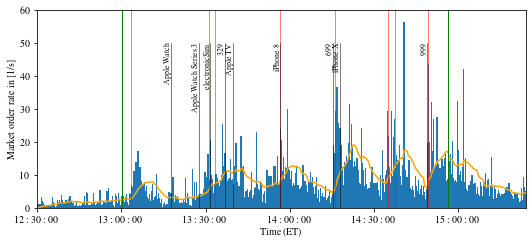

In [32]:

fig, ax = plt.subplots()

g = sa_array[0]['sa'].graphlist['marketorder_num']
t2, tbinsize, sstart, sstop = load_graph(sa)
ravg, trigger = find_trigger_points(runningavg_len=cv['trigger_param'][0], slope = cv['trigger_param'][1] ,repeat_c=cv['trigger_param'][2])

dt =((t2[0][1]-t2[0][0]).total_seconds())
ax.bar(t2[0],t2[1]/dt,width=0.15/len(t2[0]))
ax.plot(t2[0],np.array(ravg)/dt, color='orange')


for i in range(len(trigger)):
    if trigger[i]:   
        ax.plot([t2[0][i], t2[0][i]], [0,60], color='red', linewidth='0.5',clip_on=True)


ax.plot([salib.to_date_i(sstart), salib.to_date_i(sstart)], [0,60], color='green', linewidth='1',clip_on=True)
ax.plot([salib.to_date_i(sstop), salib.to_date_i(sstop)], [0,60], color='green', linewidth='1',clip_on=True)


def draw(a,b):
    st = b['first']*1000+sstart
    ax.plot([salib.to_date_i(st), salib.to_date_i(st)], [0,50], color='k', linewidth='0.5')

    ax.text(salib.to_date_i(st), 50, a, horizontalalignment='right',
     verticalalignment='top', fontsize=8, rotation=90, color='k')#, transform=ax.transAxes)

for a,b in mentions.items():
    if a not in ['Apple Watch', 'Apple Watch Series 3','electronic Sim','329','Apple TV']:
        continue
    
    draw(a,b)


for a,b in mentions_ocr.items():
    if a not in ['iPhone 8','699','iPhone X','Air Power','999']:
        continue
    draw(a,b)

ax.set_ylabel('Market order rate in [1/s]')
ax.set_xlabel('Time (ET)')
ax.set_xlim([salib.to_date_i(12.5*3600*1000),salib.to_date_i(15.4*3600*1000)])    
ax.set_ylim([0,60])
myFmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)

plt.tight_layout()
fig.savefig(folder+"res_lob30.pdf")

In [29]:
g = sa_array[0]['sa'].graphlist['marketorder_num']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


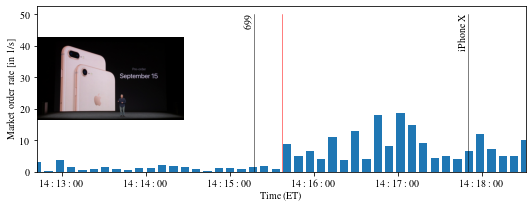

In [35]:
# When are the triggers?
tr = t2[0][trigger]
graph_pre()
for tr_i in [tr[4]]:
    fig, ax = plt.subplots()
    tr_i -= 1.25 *tbinsize
    filte['numbins']=25
    filte['range']['time'] = [salib.to_millis(tr_i)-3*60*1000, salib.to_millis(tr_i)+3*60*1000]

    t = sa['sa'].calculate_graph(g,f, histogram=True)

    dt =((t2[0][1]-t2[0][0]).total_seconds())
    ax.bar(t[0],t[1]/dt,width=0.003/len(t[0]))
    ax.plot([tr_i, tr_i], [0,50], color='red', linewidth='0.5')
    
    ax.set_xlim([t[0][0],t[0][-1]])
    
    # Get video context
    video_time = (salib.to_millis(tr_i)-sa['kn']['time_mapping'][0]['stock_time_start'])/1000

    if video_time > 0 and video_time < sa['kn']['time_mapping'][0]['video_time_end']:
        cap = cv2.VideoCapture(video_hd_folder+'/'+sa['kn']['id']+'.mp4')
        fps = cap.get(cv2.CAP_PROP_FPS)
        cap.set(cv2.CAP_PROP_POS_FRAMES, fps*video_time)
        _,img = cap.read()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


        inset_ax = inset_axes(ax,borderpad=0,
                            width="30%", # width = 30% of parent_bbox
                            height=2, # height : 1 inch
                            loc=2)
        inset_ax.axis('off')
        inset_ax.imshow(img)
    
    

    for a,b in mentions_ocr.items():
        st = b['first']*1000+sstart
        ax.plot([salib.to_date_i(st), salib.to_date_i(st)], [0,50], color='black', linewidth='0.5')
        ax.text(salib.to_date_i(st), 50, a, horizontalalignment='right', zorder=100,
         verticalalignment='top', rotation=90, color='black', clip_on=True)#, transform=ax.transAxes)

    myFmt = mdates.DateFormatter('%H:%M:%S')
    ax.xaxis.set_major_formatter(myFmt)    
    
    ax.set_ylabel('Market order rate [in 1/s]')
    ax.set_xlabel('Time (ET)')
    s = get_subtitles(sa['kn']['id'], video_time-300, video_time+60)
    #print ('\n'.join([str(a['a']/60)+' '+a['s'] for a in s]))
    
    graph_post()
    fig.savefig(folder+"res_lob31.pdf")
    